The goal of this lab is to optimize a Random Forest model using the provided dataset.  The guidance this week is less prescriptive in terms of steps, so use the skills you have gained over the semester to build and evaluate the RF model. You will be graded on your model building, interpretation of the results and explanation of model selection. As always, rely on your teams but submit your own code. Lastly, there are likely several correct approaches involving a variety of different conclusions, just make sure your conclusions are supported by your approach.    

The dataset should be familiar as it's the census data, on 32,000+ individuals with a variety of variables and a target variable for above or below 50k in salary. 

Your goal is to build a Random Forest Classifier to be able to predict income levels above or below 50k.

Answer the below questions along the way.

In [1]:
#imports...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from lime import lime_tabular
from sklearn.inspection import permutation_importance
#below is a new package needed for this lab
from ucimlrepo import fetch_ucirepo 

#for eliminating output (readability)
from IPython.display import clear_output

In [16]:
# fetch dataset 
#webpage: https://archive.ics.uci.edu/ml/datasets/Adult

adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features
y = adult.data.targets

# metadata 
#print(adult.metadata) 
  
# variable information 
#print(adult.variables)

In [17]:
#weird bug with periods added to incomes
y_target = y['income']
y_target = y_target.str.replace(".","")

# Keeping everything, only outlier variable is fnlwgt which is the census specific one:

In [18]:
numerical_cols = X.select_dtypes(include=['int', 'float']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

In [26]:
"""
Imputing and saving the columns for later
"""
from sklearn.impute import SimpleImputer

cat_imputer = SimpleImputer(strategy="most_frequent")

num_imputer = SimpleImputer(strategy="mean")

X_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(X[categorical_cols]), columns=categorical_cols)
X_num_imputed = pd.DataFrame(num_imputer.fit_transform(X[numerical_cols]), columns=numerical_cols)


one_hot_cols = pd.get_dummies(X_cat_imputed, columns=X_cat_imputed.columns)
cols_to_drop = X_cat_imputed.columns

X_dropped = X.drop(columns=cols_to_drop)
X_prepared = pd.concat([X_dropped, one_hot_cols], axis=1)

cols_saved = X_prepared.columns

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y_target, train_size=0.8)

In [30]:
#Build the RF model using default values from the in class example

In [38]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': 100,            # Number of trees in the forest
    'max_depth': 25,               # Maximum depth of each tree
    'min_samples_split': 2,        # Minimum samples required to split a node
    'min_samples_leaf': 1,         # Minimum samples required to be in a leaf node
    'max_features': 'sqrt',        # Maximum number of features to consider for split
    'bootstrap': True,             # Use bootstrapping
    'random_state': 42,            # Seed for random number generator (for reproducibility)
    'class_weight': None,          # You can specify class weights if needed
    'n_jobs': -1,                   # Number of CPU cores to use (-1 to use all)
    "oob_score": True
}

model = RandomForestClassifier(**param_grid)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, n_jobs=-1, oob_score=True, random_state=42)

In [39]:
y_pred = model.predict(X_test)

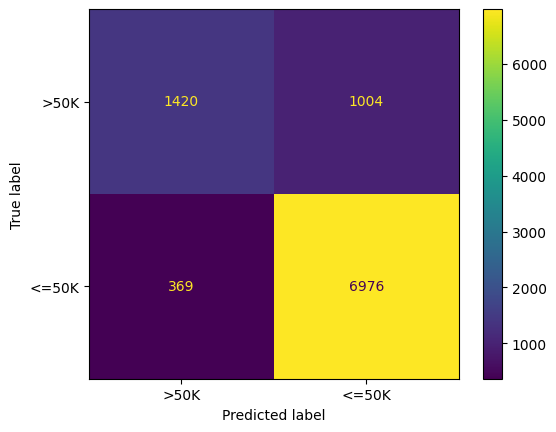

In [40]:
labels = ['>50K', '<=50K']

conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
plot = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
plot.plot()

In [41]:
#How did the training process perform? What is the precision, recall, and accuracy of the model? What is the 
#out of bad error rate? Display the confusion matrix.

In [42]:
precision = precision_score(y_test, y_pred, pos_label='>50K')
recall = recall_score(y_test, y_pred, pos_label=">50K") 
accuracy = accuracy_score(y_test, y_pred) 


print(f"Precision: {precision}\nRecall: {recall}\nAccuracy: {accuracy} \nOut-Of-Bag Error: {1-model.oob_score_}")

Precision: 0.7937395192845165
Recall: 0.5858085808580858
Accuracy: 0.8594533729143208 
Out-Of-Bag Error: 0.13653929823663402


In [44]:
#Which row in the data has the highest probability of being a positive case? Which row has the highest probability
#of being a negative case?

y_pred_proba = model.predict_proba(X_test)

# Find the row index with the highest probability for class 1 (positive case)
highest_prob_positive_row_idx = y_pred_proba[:, 1].argmax()

# Find the row index with the highest probability for class 0 (negative case)
highest_prob_negative_row_idx = y_pred_proba[:, 0].argmax()

# Extract the actual data rows corresponding to these indices
row_with_highest_prob_positive = X_test.iloc[highest_prob_positive_row_idx]
row_with_highest_prob_negative = X_test.iloc[highest_prob_negative_row_idx]

# You can also get the predicted probabilities themselves
highest_prob_positive = y_pred_proba[highest_prob_positive_row_idx, 1]
highest_prob_negative = y_pred_proba[highest_prob_negative_row_idx, 0]

print("Row with Highest Probability of Being Positive (Class '>50K'):\n")
print(row_with_highest_prob_positive)
print("Predicted Probability of Being Positive:", highest_prob_positive)

print("\nRow with Highest Probability of Being Negative (Class '<=50K'):\n")
print(row_with_highest_prob_negative)
print("Predicted Probability of Being Negative:", highest_prob_negative)



Row with Highest Probability of Being Positive (Class '>50K'):

age                                   51
fnlwgt                            229465
education-num                         14
capital-gain                       15024
capital-loss                           0
                                   ...  
native-country_Thailand            False
native-country_Trinadad&Tobago     False
native-country_United-States        True
native-country_Vietnam             False
native-country_Yugoslavia          False
Name: 1250, Length: 108, dtype: object
Predicted Probability of Being Positive: 0.9985309973045822

Row with Highest Probability of Being Negative (Class '<=50K'):

age                                   19
fnlwgt                            121972
education-num                          9
capital-gain                           0
capital-loss                           0
                                   ...  
native-country_Thailand            False
native-country_Trinadad&Tobago   

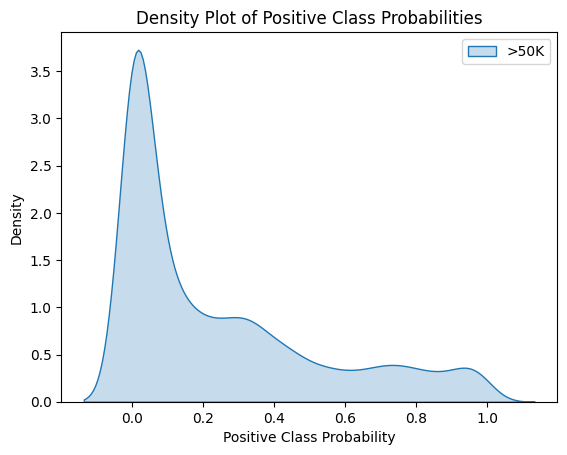

In [45]:
#Create a density plot of the positive class probabilities and comment on the pattern you see.

"""
The below visual makes sense, as the probability of having a >50K salary rises, the number of people predicted to have that salary (Density) decreases. 
"""

import seaborn as sns
import matplotlib.pyplot as plt

positive_probabilities = [item[1] for item in y_pred_proba]

# Create a density plot
sns.kdeplot(positive_probabilities, fill=True, label=">50K")

# Add labels and a title
plt.xlabel('Positive Class Probability')
plt.ylabel('Density')
plt.title('Density Plot of Positive Class Probabilities')
plt.legend()


# Show the plot
plt.show()

In [53]:
#Create a sorted list of feature importances and comment on the top features. Are there a few that seem
#to be more important than the others?


importance_scores = model.feature_importances_

df = pd.DataFrame({'Feature': cols_saved, 'Importance': importance_scores})

df = df.sort_values(by="Importance", ascending=False)


for feature, importance in zip(df['Feature'], df['Importance']):
    print(f"Feature {feature}, Importance {importance}")


Feature capital-gain, Importance 0.1208071940625152
Feature age, Importance 0.11341402607019765
Feature marital-status_Married-civ-spouse, Importance 0.09885708948964277
Feature fnlwgt, Importance 0.0873473011120682
Feature education-num, Importance 0.08172791436871955
Feature hours-per-week, Importance 0.07217581951073489
Feature relationship_Husband, Importance 0.05248649958556263
Feature capital-loss, Importance 0.0368716733743518
Feature marital-status_Never-married, Importance 0.027696325921664558
Feature occupation_Exec-managerial, Importance 0.01992125336177466
Feature education_Bachelors, Importance 0.016330727515244718
Feature relationship_Not-in-family, Importance 0.015982457807245658
Feature occupation_Prof-specialty, Importance 0.014013758520971064
Feature education_Masters, Importance 0.012690425035184107
Feature sex_Female, Importance 0.012023541371202722
Feature relationship_Wife, Importance 0.010478998335633954
Feature relationship_Own-child, Importance 0.01040121438507

In [64]:
#Generate feature importances using permutation importance, with precision as the metric. Do the results match 
#the feature importances from above? If they are different what might be the reason?

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

def custom_precision_scorer(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label='>50K')  # Set the appropriate positive label

# Create a scorer based on the custom precision scoring function
precision_scorer = make_scorer(custom_precision_scorer)

perm_importance = permutation_importance(model, X_test, y_test, scoring=precision_scorer, n_repeats=5, random_state=0)

In [82]:
"""
Age took a backseat to education_num as did marital status. This is more or less expected though as those characteristics are intrinsic to an individual person.
"""

df = pd.DataFrame({'Feature': cols_saved, 'Importance': pd.Series(perm_importance['importances_mean'])})

df = df.sort_values(by="Importance", ascending=False)

for feature, importance in zip(df['Feature'], df['Importance']):
    print(f"Feature {feature}, Importance {importance}")

Feature capital-gain, Importance 0.11426542967170472
Feature capital-loss, Importance 0.0218955873151379
Feature education-num, Importance 0.014087572503864765
Feature fnlwgt, Importance 0.006726312868405038
Feature workclass_Self-emp-not-inc, Importance 0.006002227493404955
Feature occupation_Exec-managerial, Importance 0.005342832119721907
Feature education_Bachelors, Importance 0.0037849264500118716
Feature occupation_Transport-moving, Importance 0.0030127435765105125
Feature occupation_Farming-fishing, Importance 0.00288345701374475
Feature workclass_?, Importance 0.0015143328241212118
Feature race_Black, Importance 0.001250261112661266
Feature education_Masters, Importance 0.0011247536324658024
Feature native-country_United-States, Importance 0.0009795726057182153
Feature occupation_?, Importance 0.0008710587044976848
Feature race_Asian-Pac-Islander, Importance 0.0008691336508838798
Feature age, Importance 0.0006170795008221708
Feature native-country_Canada, Importance 0.000581969

In [ ]:
#Select the optimal number of trees for the model and retrain the model. 

In [ ]:
#Select the optimal number of features for the model and retrain the model.

In [105]:
param_grid = {
    'n_estimators': 150,            # Number of trees in the forest
    'max_depth': 50,               # Maximum depth of each tree
    'min_samples_split': 3,        # Minimum samples required to split a node
    'min_samples_leaf': 1,         # Minimum samples required to be in a leaf node
    'max_features': 5,        # Maximum number of features to consider for split
    'bootstrap': True,             # Use bootstrapping
    'random_state': 42,            # Seed for random number generator (for reproducibility)
    'n_jobs': -1,                   # Number of CPU cores to use (-1 to use all)
    "oob_score": True
}

model_good = RandomForestClassifier(**param_grid)

model_good.fit(X_train, y_train)

y_pred_proba = model_good.predict_proba(X_test)
y_pred = model_good.predict(X_test)


precision = precision_score(y_test, y_pred, pos_label='>50K')
recall = recall_score(y_test, y_pred, pos_label=">50K") 
accuracy = accuracy_score(y_test, y_pred) 


print(f"Precision: {precision}\nRecall: {recall}\nAccuracy: {accuracy} \nOut-Of-Bag Error: {1-model_good.oob_score_}")

Precision: 0.7507804370447451
Recall: 0.5952970297029703
Accuracy: 0.8505476507319071 
Out-Of-Bag Error: 0.1448570624216211


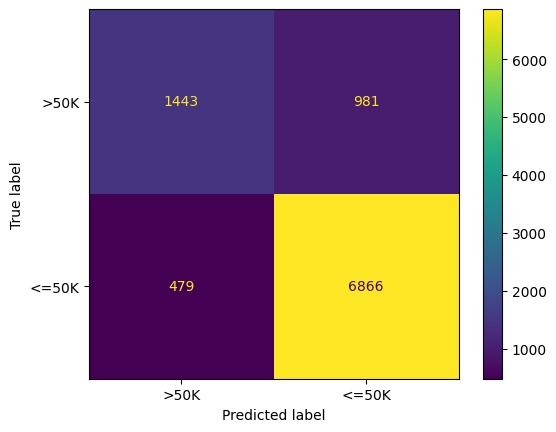

In [106]:
#Compare the new tree to the original tree. What is the difference in the OOBE and confusion matrix? Which
#features contibute the most

"""
OOBE is slightly higher, but because our goal was precision we did everything we could to maximize this, which you can see above with the 59%.
"""

labels = ['>50K', '<=50K']

conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
plot = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
plot.plot()

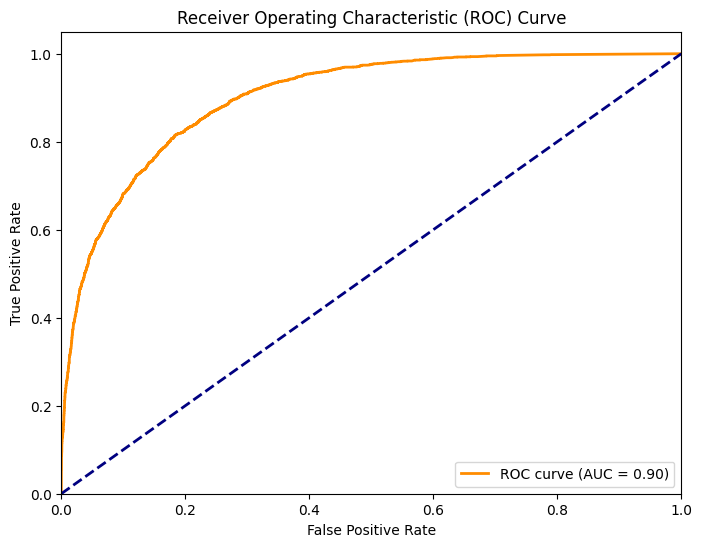

In [108]:
#Predict with the test set and discuss the models performance, include the ROC curve and AUC.

"""
ROC Curve is pretty standard for a difficult classification problem, Ideally it would be more steep, but we spent a long time fine tuning and were barely able to get precision to the 
59% above. This could definitely be worse though.
"""

from sklearn.metrics import roc_curve, auc

y_scores = model_good.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label='>50K')

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [109]:
"""
Importances: 
"""

importance_scores = model_good.feature_importances_

df = pd.DataFrame({'Feature': cols_saved, 'Importance': importance_scores})

df = df.sort_values(by="Importance", ascending=False)


for feature, importance in zip(df['Feature'], df['Importance']):
    print(f"Feature {feature}, Importance {importance}")


Feature age, Importance 0.15337762211379252
Feature fnlwgt, Importance 0.14638632558260195
Feature capital-gain, Importance 0.09529746565660366
Feature hours-per-week, Importance 0.08409382578638745
Feature marital-status_Married-civ-spouse, Importance 0.06345100998077538
Feature education-num, Importance 0.05016290994981475
Feature relationship_Husband, Importance 0.03617627275884294
Feature capital-loss, Importance 0.03143029390354823
Feature marital-status_Never-married, Importance 0.0279888793420272
Feature occupation_Exec-managerial, Importance 0.02024717302658261
Feature relationship_Not-in-family, Importance 0.01632106633512691
Feature education_Bachelors, Importance 0.01548083983771777
Feature occupation_Prof-specialty, Importance 0.013983579320201181
Feature education_Masters, Importance 0.010989113272005337
Feature sex_Female, Importance 0.010794439776242653
Feature relationship_Wife, Importance 0.010354132448305853
Feature relationship_Own-child, Importance 0.009933080821304

In [ ]:
#Bonus (7 points) - Use the LIME package to show the why one row in the test set was classified as positive.